# Classification of a time series using Keras

In this example, we use time series data for classification. The following tasks are already completed:

    1. Data is clean (data gaps imputed, NaN columns deleted)
    2. Non-numeric data is encoded into numeric data types.
    3. Dimensionality reduction is alredy done.
    4. Sequence lengths have been determined through domain knowledge and signal processing.

### Import some libraries

In [1]:
import numpy as np 
import pandas as pd

import keras as K
from keras.models import *

from keras.layers.core import *
from keras.optimizers import RMSprop, Adam
from keras.layers import LSTM
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier


# from sklearn.preprocessing import MinMaxScaler
# from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import pickle

np.random.seed(500)

Using TensorFlow backend.


In [2]:
from scipy.stats import expon, randint
from keras.utils import np_utils
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.externals import joblib
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

from sklearn.model_selection import learning_curve
from sklearn.model_selection import KFold

from sklearn.preprocessing import StandardScaler, MinMaxScaler


/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


### Read the data 

In [3]:
# read files
X_train_df = pd.read_parquet('X_train_df.parquet')
X_test_df = pd.read_parquet('X_test_df.parquet')
y_train_df = pd.read_parquet('y_train_df.parquet')
y_test_df = pd.read_parquet('y_test_df.parquet')

In [4]:
print(X_train_df.shape)
print(X_test_df.shape)
print(y_train_df.shape)
print(y_test_df.shape)

(214171, 448)
(91805, 448)
(3511, 1)
(1505, 1)


### Convert input to 3D tensor for LSTM. If you are using a CNN, remember to embed the input accordingly. 
### We'll have a CNN in a later post.

In [5]:
# reshape the data for LSTM
time_steps = 61  # sequence length
num_classes= 9
X_train = np.reshape(X_train_df.values, (int(X_train_df.shape[0]/time_steps), time_steps, X_train_df.shape[1]))
X_test = np.reshape(X_test_df.values, (int(X_test_df.shape[0]/time_steps), time_steps, X_test_df.shape[1]))

y_train = np_utils.to_categorical(y_train_df, num_classes, dtype='float32')
y_test = np_utils.to_categorical(y_test_df, num_classes, dtype='float32')
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3511, 61, 448)
(1505, 61, 448)
(3511, 9)
(1505, 9)


# Build a keras model

In [6]:
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers.recurrent import LSTM


def build_model_lstm(time_steps, feats_dim, num_classes, optimizer='rmsprop', 
        init='glorot_uniform'):
    x_in = Input(shape=(time_steps, feats_dim))
    h1 = LSTM(128,return_sequences=True)(x_in)
    h1 = Dropout(0.5)(h1)
    h2 = LSTM(64,return_sequences=True)(h1)
    h2 = Dropout(0.5)(h2)
    h3 = LSTM(32,return_sequences=True)(h2)
    h4 = LSTM(32)(h3)
    h4 = Dropout(0.5)(h4)
    out = Dense(num_classes, kernel_initializer=init, 
                   activation='softmax')(h4)
    model = Model(inputs=x_in, outputs=out)
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model 

In [7]:
def train_model(model, X_train, y_train, batch_size = 32, 
        epochs=2000, shuffle = True):
    es = EarlyStopping(monitor='val_loss', verbose=1, patience=5, min_delta=10e-6)
    mc = ModelCheckpoint('best_model_LSTM_example.h5', monitor='val_loss', verbose=1, save_best_only=True)
    
    if len(X_train) % 2 == 1:  # if len(X_train) is odd
        X_train = X_train[:-1,:]
        y_train = y_train[:-1,:]
    x_val = X_train[:int(len(X_train)*0.2)]
    y_val = y_train[:int(len(X_train)*0.2)]
    
    
    
    history = model.fit(X_train, y_train, batch_size, epochs, shuffle, validation_data=(x_val, y_val) ,callbacks=[es, mc])
    
    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    trained_model = model
    return trained_model

In [8]:
feats_dim = X_train.shape[2]
model = build_model_lstm(time_steps, feats_dim, num_classes)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 61, 448)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 61, 128)           295424    
_________________________________________________________________
dropout_1 (Dropout)          (None, 61, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 61, 64)            49408     
_________________________________________________________________
dropout_2 (Dropout)          (None, 61, 64)            0         
_________________________________________________________________
lstm_3 (LSTM)        

## Train the model

Instructions for updating:
Use tf.cast instead.
Train on 3510 samples, validate on 702 samples
Epoch 1/200
3510/3510 [==============================] - 42s 12ms/step - loss: 0.8590 - acc: 0.7957 - val_loss: 0.4433 - val_acc: 0.8960

Epoch 00001: val_loss improved from inf to 0.44334, saving model to best_model_LSTM_example.h5
Epoch 2/200
3510/3510 [==============================] - 38s 11ms/step - loss: 0.4538 - acc: 0.8912 - val_loss: 0.3318 - val_acc: 0.9103

Epoch 00002: val_loss improved from 0.44334 to 0.33176, saving model to best_model_LSTM_example.h5
Epoch 3/200
3510/3510 [==============================] - 40s 11ms/step - loss: 0.3714 - acc: 0.9097 - val_loss: 0.2765 - val_acc: 0.9274

Epoch 00003: val_loss improved from 0.33176 to 0.27654, saving model to best_model_LSTM_example.h5
Epoch 4/200
3510/3510 [==============================] - 39s 11ms/step - loss: 0.3000 - acc: 0.9259 - val_loss: 0.2433 - val_acc: 0.9444

Epoch 00004: val_loss improved from 0.27654 to 0.24328, savi

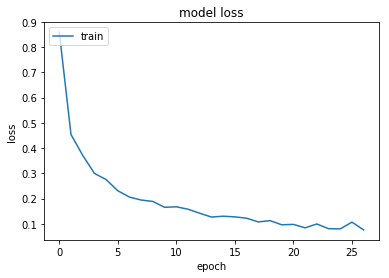

In [9]:
train_model(model, X_train, y_train, 32,200)

# Inspect prediction accuracy

In [10]:
lstm_score_train = model.evaluate(X_train,y_train)
print(lstm_score_train)

3511/3511 [==============================] - 14s 4ms/step
[0.08269726071049897, 0.9737966391341498]


In [11]:
lstm_score_test = model.evaluate(X_test,y_test)
print(lstm_score_test)

1505/1505 [==============================] - 6s 4ms/step
[0.2143229364015261, 0.9534883720930233]
